In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchaudio
import librosa
import torchaudio.transforms as trans
from wavenet import WaveNet

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

In [3]:
from torch.utils.data import Dataset,DataLoader
from torchaudio import transforms
import glob

In [4]:

audio,_ = librosa.load('./VCTK/p225/p225_001.wav',sr=16000,mono=True)
audio,_ = librosa.effects.trim(audio, top_db=10, frame_length=2048)
wav_tensor = torch.from_numpy(audio).unsqueeze(1)
wav_tensor = trans.MuLawEncoding()(wav_tensor).transpose(0,1)

In [5]:
model = WaveNet().cuda()
model.load_state_dict(torch.load('model_300.pth'))

In [16]:
model.receptive_field

5117

In [6]:
recp_field=5117
sample_len = 16000*3
sample = Variable(wav_tensor[:,:recp_field]).long().cuda()

In [18]:
sample

Variable containing:
  161   105    95  ...     57   196    84
[torch.cuda.LongTensor of size 1x5117 (GPU 0)]

In [19]:
logits = model(sample[:,-recp_field:])[:,:,-1].squeeze()
prob = F.softmax(logits,dim=0)
prob = prob.cpu()
np_prob = prob.data.numpy()
x = np.random.choice(256,p=np_prob)
new = Variable(torch.LongTensor([x])).view(-1,1).cuda()
#print sample.size(),new.size()
sample = torch.cat((sample,new),dim=1)
print sample.size()


torch.Size([1, 5118])


In [20]:
new

Variable containing:
 174
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

In [7]:
for i in range(sample_len):
    logits = model(sample[:,-recp_field:])[:,:,-1].squeeze()
    prob = F.softmax(logits,dim=0)
    prob = prob.cpu()
    np_prob = prob.data.numpy()
    x = np.random.choice(256,p=np_prob)
    new = Variable(torch.LongTensor([x])).view(-1,1).cuda()
#print sample.size(),new.size()
    sample = torch.cat((sample,new),dim=1)
    #print sample.size()
    if i % 16000 == 0:
        print i

0
16000
32000


In [12]:
sample[:,-recp_field:]

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1522182087074/work/torch/lib/THC/generic/THCTensorCopy.c:70

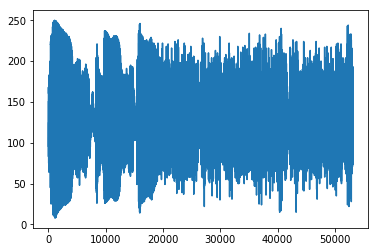

In [9]:
plt.plot(sample.cpu().data.numpy()[0])

In [10]:

sample = trans.MuLawExpanding()(sample.cpu().data)
librosa.output.write_wav("sample.wav",sample.numpy()[0],sr=16000)